##**Submission NLP**

Saya akan membuat prediksi genre (komedi, horor, action) suatu film berdasarkan plot yang disediakan. Untuk datasetnya, saya mengambil dari https://www.kaggle.com/jrobischon/wikipedia-movie-plots

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/wiki_movie_plots_deduped.csv')

#melihat jumlah data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [3]:
#saya hanya memerlukan kolom Genre dengan Plot
df = df[['Genre', 'Plot']]

#kemudian mari kita lihat persebaran genre
df['Genre'].value_counts()

unknown                                               6083
drama                                                 5964
comedy                                                4379
horror                                                1167
action                                                1098
                                                      ... 
action / adventure / thriller                            1
fantasy, drama, children's, sci-fi, adventure, spy       1
animation, fantasy                                       1
action, comedy, drama, romance                           1
fantasy romance, horror                                  1
Name: Genre, Length: 2265, dtype: int64

In [4]:
#saya hanya akan memilih 3 genre saja yaitu comedy, horror, dan action
label = ['comedy', 'horror', 'action']
movie = df[df['Genre'].isin(label)].reset_index()

#jika dilihat dari persebaran genre, genre comedy memiliki jumlah yang lebih besar (tidak seimbang)
#oleh karena itu saya ingin menyamakan jumlah semua genre masing-masing 1000
comedy = movie[movie['Genre']=='comedy'].iloc[:1000]
horror = movie[movie['Genre']=='horror'].iloc[:1000]
action = movie[movie['Genre']=='action'].iloc[:1000]

clean_movie = pd.concat([comedy,horror,action], ignore_index=True)
clean_movie = clean_movie[['Plot','Genre']]

#karena label berupa data kategorikal maka harus dilakukan one hot encoding terlebih dahulu
category = pd.get_dummies(clean_movie['Genre'])
movie_new = pd.concat([clean_movie, category], axis=1)
movie_new = movie_new.drop(columns='Genre')
movie_new.head()

,Plot,action,comedy,horror
0,The film is about a family who move to the sub...,0,1,0
1,Before heading out to a baseball game at a nea...,0,1,0
2,The plot is that of a black woman going to the...,0,1,0
3,A young couple decides to elope after being ca...,0,1,0
4,Hemlock Hoax is a detective who has little res...,0,1,0


In [5]:
#setelah data sudah bersih saatnya membagi data menjadi data latih dan data test

from sklearn.model_selection import train_test_split
X = movie_new['Plot'].values
y = movie_new.drop(columns='Plot').values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


In [6]:
#selanjutnya mengubah kata dalam plot menjadi numerik dan melakukan normalisasi
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=8500, oov_token='x')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

#transform
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq  = tokenizer.texts_to_sequences(X_test)

#normalisasi
train_pad = pad_sequences(train_seq)
test_pad  = pad_sequences(test_seq)



In [7]:
#callback
import tensorflow as tf

class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>0.95):
        print("\nAkurasi telah mencapai >95%!")
        self.model.stop_training = True
callback = Callback()  

In [11]:
#selanjutnya membuat model kemudian melatih model

import tensorflow as tf
model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(input_dim=8500, output_dim=16),
                              tf.keras.layers.LSTM(64),
                              tf.keras.layers.Dense(256, activation='relu'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(64),
                              tf.keras.layers.Dense(3, activation='softmax')
                            ])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_pad, y_train, epochs=30, 
                    validation_data=(test_pad, y_test), verbose=2, callbacks=[callback])


Epoch 1/30
75/75 - 84s - loss: 1.0993 - accuracy: 0.3329 - val_loss: 1.0895 - val_accuracy: 0.4917
Epoch 2/30
75/75 - 81s - loss: 0.9594 - accuracy: 0.5092 - val_loss: 0.8294 - val_accuracy: 0.6283
Epoch 3/30
75/75 - 82s - loss: 0.5079 - accuracy: 0.8067 - val_loss: 0.7148 - val_accuracy: 0.7250
Epoch 4/30

Akurasi telah mencapai >95%!
75/75 - 84s - loss: 0.1373 - accuracy: 0.9521 - val_loss: 0.9035 - val_accuracy: 0.7717


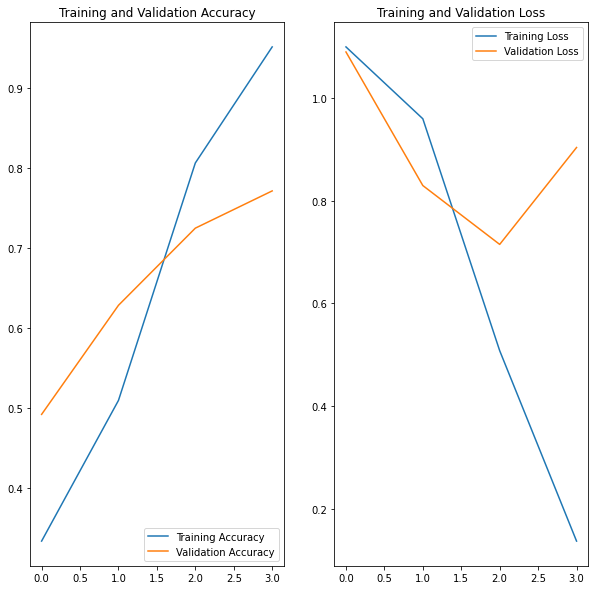

In [13]:
#plot akurasi
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(4) 
plt.figure(figsize=(10, 10))

#visualisasi training and validation accurancy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#visualisasi training and validation loss 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()